In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
from tqdm import tqdm #Progress bar

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!nvidia-smi

Mon Jan 16 13:18:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#file paths
base_url = "../input/plant-pathology-2020-fgvc7"
image_dir = f"{base_url}/images"
train = f"{base_url}/train.csv"
test = f"{base_url}/test.csv"

### Analyse Data

In [4]:
test_data = pd.read_csv(test) #Test Data
train_data = pd.read_csv(train) #Train Data

train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


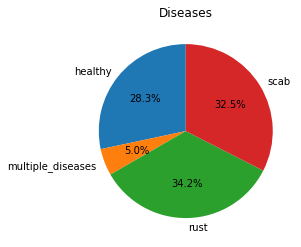

In [5]:
columns = ['healthy','multiple_diseases','rust','scab']
count = []

for i in columns:
    count.append(train_data[i].sum())

# Plot a pie chart
plt.pie(count, labels=columns, autopct='%1.1f%%', startangle=90)
plt.title("Diseases")
plt.show()

### Read and Pre-Process images

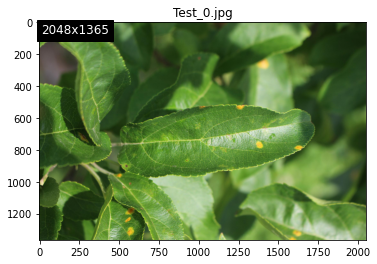

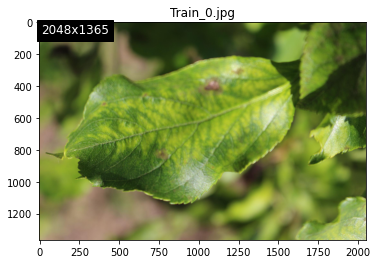

In [6]:
index = 0

test_img = f"{image_dir}/Test_{index}.jpg"
train_img = f"{image_dir}/Train_{index}.jpg"

# Iterate through the list of images
for file in [test_img,train_img]:
    image = Image.open(file)
    plt.imshow(image)
    plt.text(x=10, y=70, s=f'{image.size[0]}x{image.size[1]}', fontsize=12, color='white', backgroundcolor='black')
    plt.title(os.path.basename(file))
    plt.show()

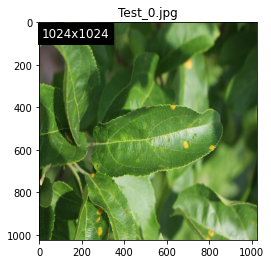

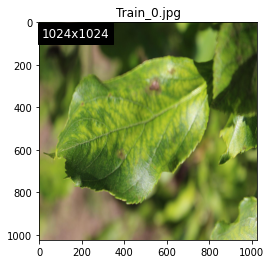

In [7]:
index = 0
new_size = (1024, 1024) #Resize images

test_img = f"{image_dir}/Test_{index}.jpg"
train_img = f"{image_dir}/Train_{index}.jpg"

# Iterate through the list of images
for file in [test_img,train_img]:
    image = Image.open(file).resize(new_size) #Resize
    plt.imshow(image)
    plt.text(x=10, y=70, s=f'{image.size[0]}x{image.size[1]}', fontsize=12, color='white', backgroundcolor='black')
    plt.title(os.path.basename(file))
    plt.show()

In [8]:
# def PreProcess(Dataset, size):
#     height, width = size

#     ids = Dataset['image_id']
#     Y = np.array(Dataset.drop(columns=['image_id']))

#     X = np.zeros((len(ids), height, width, 3))

#     for i, id_ in enumerate(ids):
#         img = tf.io.decode_image(tf.io.read_file(os.path.join(image_dir, "{}.jpg".format(id_))),channels=3)
#         img = tf.image.resize(img, size)
#         img = img / 255
#         X[i] = img
    
#     return ids, X, Y

In [9]:
def PreProcess(Dataset, size):
    height, width = size

    ids = Dataset['image_id']
    Y = np.array(Dataset.drop(columns=['image_id']))

    def image_process():
        for id_ in tqdm(ids):
            img = tf.io.decode_image(tf.io.read_file(os.path.join(image_dir, "{}.jpg".format(id_))), channels=3)
            img = tf.image.resize(img, size)
            img = img / 255.0
            yield img

    X = np.array(list(image_process()))

    return ids, X, Y

In [10]:
# def PreProcess(Dataset, size):
#     ids = Dataset['image_id']
#     Y = tf.data.Dataset.from_tensor_slices(np.array(Dataset.drop(columns=['image_id'])))

#     # Create a dataset
#     img_id_ds = tf.data.Dataset.from_tensor_slices(ids)
#     img_ds = img_id_ds.map(lambda x:tf.image.decode_jpeg(tf.io.read_file(os.path.join(image_dir, "Test_0.jpg".format(x))), channels=3))
#     img_ds = img_ds.map(lambda x:tf.image.resize(x, size))
#     img_ds = img_ds.map(lambda x:x/255)
    
#     dataset = tf.data.Dataset.zip((img_ds, Y))
    
#     # Shuffle and batch the dataset
#     dataset = dataset.shuffle(buffer_size=1000).batch(128)
    
#     dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
#     return dataset

In [11]:
image_size = [224,224]

#Pre-Process train images
ids,X,Y = PreProcess(train_data,image_size) 

  0%|          | 0/1821 [00:00<?, ?it/s]2023-01-16 13:18:47.731724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 13:18:47.839572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 13:18:47.840341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 13:18:47.843276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

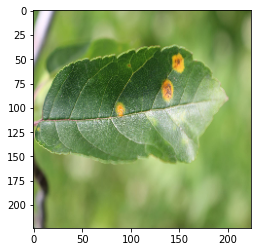

In [12]:
# Check pre-processed data
index = 3

plt.imshow(X[index])

In [13]:
print(f"X shape = {X.shape}")
print(f"Y shape = {Y.shape}")

X shape = (1821, 224, 224, 3)
Y shape = (1821, 4)


In [14]:
if np.isnan(X).any() or np.isnan(Y).any():
    print("Arrays has null values.")
else:
    print("Arrays has no null values.")

Arrays has no null values.


### Validation Split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

print(f"X train shape = {X_train.shape}")
print(f"X validation shape = {X_val.shape}")
print(f"y train shape = {y_train.shape}")
print(f"y validation shape = {y_val.shape}")

X train shape = (1456, 224, 224, 3)
X validation shape = (365, 224, 224, 3)
y train shape = (1456, 4)
y validation shape = (365, 4)


In [16]:
#Clear memory
del X,Y

### Data augmentation

In [17]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)

In [18]:
# Use the generator to create augmented versions of the data
X_augmented, y_augmented = datagen.flow(X_train, y_train, batch_size=1024).next()

# Concatenate the original and augmented data
X_train = np.concatenate((X_train, X_augmented))
y_train = np.concatenate((y_train, y_augmented))

print(f"X train shape = {X_train.shape}")
print(f"Y train shape = {y_train.shape}")

X train shape = (2480, 224, 224, 3)
Y train shape = (2480, 4)


In [19]:
#Clear memory
del X_augmented,y_augmented

### Model

In [20]:
def bottleneck_identity(X, f, filters,dropout=0.3, training=True,initializer = 'he_uniform'):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer )(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Dropout(dropout)(X)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

In [21]:
def bottleneck_projection(X, f, filters, s = 2, dropout=0.5,training=True,initializer = 'he_uniform'):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Dropout(dropout)(X)
    
   # projection
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer)(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [22]:
# A plain model which uses dense layers

# def ResNet(image_size):
    
#     height,width = image_size
#     input_shape = (height,width,3)
    
#     inputs = Input(input_shape)
    
#     X = ZeroPadding2D((2, 2))(inputs)
    
#     X = Conv2D(64, (7, 7), strides = (2, 2),padding="valid")(X)
#     X = BatchNormalization(axis = 3)(X)
#     X = Activation('relu')(X)
#     X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
#     X = bottleneck_identity(X, 3, [32, 32, 64])               
#     X = bottleneck_identity(X, 3, [32, 32, 64]) 
    
#     X = bottleneck_projection(X, f = 3, filters = [64, 64, 256], s = 2)
#     X = bottleneck_identity(X, 3, [64, 64, 256])               
#     X = bottleneck_identity(X, 3, [64, 64, 256]) 
    
#     X = bottleneck_projection(X, f = 3, filters = [128, 128, 512], s = 2)
#     X = bottleneck_identity(X, 3, [128, 128, 512])               
#     X = bottleneck_identity(X, 3, [128, 128, 512])
    
#     X = bottleneck_projection(X, f = 3, filters = [256, 256, 1024], s = 2)
#     X = bottleneck_identity(X, 3, [256, 256, 1024])               
#     X = bottleneck_identity(X, 3, [256, 256, 1024])
    
    
#     ## AVGPOOL 
#     X = AveragePooling2D((3,3),strides=(1,1))(X)
    
#     X = Flatten()(X)
#     X = Dense(4, activation='softmax')(X)
    
#     # Create model
#     model = Model(inputs = inputs, outputs = X)
    
#     return model

## ResNet18

In [23]:
def ResNet18(image_size):
    
    height,width = image_size
    input_shape = (height,width,3)
    
    inputs = Input(input_shape)
    
#     X = ZeroPadding2D((2, 2))(inputs)
    
    X = Conv2D(64, (7, 7), strides = (2, 2),padding="valid")(inputs)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = bottleneck_identity(X, 3, [32, 32, 64])               
    X = bottleneck_identity(X, 3, [32, 32, 64]) 
    
    X = bottleneck_projection(X, f = 3, filters = [64, 64, 128], s = 2)
    X = bottleneck_identity(X, 3, [64, 64, 128])  
    
    X = bottleneck_projection(X, f = 3, filters = [64, 64, 256], s = 2)
    X = bottleneck_identity(X, 3, [128, 128, 256])
    
    X = bottleneck_projection(X, f = 3, filters = [128, 128, 512], s = 2)
    X = bottleneck_identity(X, 3, [256, 256, 512])
    
    
    ## AVGPOOL 
    X = AveragePooling2D((3,3),strides=(1,1))(X)
    
    X = Flatten()(X)
    X = Dense(4, activation='softmax')(X)
    
    # Create model
    model = Model(inputs = inputs, outputs = X)
    
    return model

## ResNet34

In [24]:
def ResNet34(image_size):
    
    height,width = image_size
    input_shape = (height,width,3)
    
    inputs = Input(input_shape)
    
    X = ZeroPadding2D((2, 2))(inputs)
    
    X = Conv2D(64, (7, 7), strides = (2, 2),padding="valid")(inputs)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = bottleneck_identity(X, 3, [32, 32, 64])               
    X = bottleneck_identity(X, 3, [32, 32, 64])
    X = bottleneck_identity(X, 3, [32, 32, 64])
    
    X = bottleneck_projection(X, f = 3, filters = [64, 64, 128], s = 2)
    X = bottleneck_identity(X, 3, [64, 64, 128])  
    X = bottleneck_identity(X, 3, [64, 64, 128]) 
    X = bottleneck_identity(X, 3, [64, 64, 128]) 
    
    X = bottleneck_projection(X, f = 3, filters = [64, 64, 256], s = 2)
    X = bottleneck_identity(X, 3, [128, 128, 256])
    X = bottleneck_identity(X, 3, [128, 128, 256])
    X = bottleneck_identity(X, 3, [128, 128, 256])
    X = bottleneck_identity(X, 3, [128, 128, 256])
    X = bottleneck_identity(X, 3, [128, 128, 256])
    
    X = bottleneck_projection(X, f = 3, filters = [128, 128, 512], s = 2)
    X = bottleneck_identity(X, 3, [256, 256, 512])
    X = bottleneck_identity(X, 3, [256, 256, 512])
    X = bottleneck_identity(X, 3, [256, 256, 512])
    
    ## AVGPOOL 
    X = AveragePooling2D((3,3),strides=(1,1))(X)
    
    X = Flatten()(X)
    X = Dense(4, activation='softmax')(X)
    
    # Create model
    model = Model(inputs = inputs, outputs = X)
    
    return model

In [25]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [26]:
# # instantiating the model in the strategy scope creates the model on the TPU
# # with tpu_strategy.scope():
#     model = ResNet(image_size) # define your model normally
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Clear prevoius sessions
tf.keras.backend.clear_session()

In [28]:
model = ResNet34(image_size)
optimizer = Adam(learning_rate=0.1,decay=0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 109, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 109, 109, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [30]:
history = model.fit(X_train,y_train, epochs = 30,batch_size=128, validation_data=(X_val,y_val))

2023-01-16 13:19:47.500639: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1493237760 exceeds 10% of free system memory.
2023-01-16 13:19:49.193412: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1493237760 exceeds 10% of free system memory.
2023-01-16 13:19:50.394744: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-16 13:19:57.270402: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 20s 342ms/step - loss: 8.8831 - accuracy: 0.3081 - val_loss: 3.1911 - val_accuracy: 0.3233
Epoch 2/30
20/20 [==============================] - 5s 253ms/step - loss: 2.1261 - accuracy: 0.3371 - val_loss: 1.5654 - val_accuracy: 0.3288
Epoch 3/30
20/20 [==============================] - 5s 255ms/step - loss: 1.4593 - accuracy: 0.3653 - val_loss: 1.4136 - val_accuracy: 0.3315
Epoch 4/30
20/20 [==============================] - 5s 254ms/step - loss: 1.3855 - accuracy: 0.3444 - val_loss: 1.4861 - val_accuracy: 0.3151
Epoch 5/30
20/20 [==============================] - 5s 262ms/step - loss: 1.4147 - accuracy: 0.3504 - val_loss: 1.3764 - val_accuracy: 0.3644
Epoch 6/30
20/20 [==============================] - 5s 253ms/step - loss: 1.3999 - accuracy: 0.3694 - val_loss: 1.3333 - val_accuracy: 0.3342
Epoch 7/30
20/20 [==============================] - 5s 254ms/step - loss: 1.3423 - accuracy: 0.4044 - val_loss: 1.4059 - val_accuracy: 0.4082
Epoch 8/30
20/20

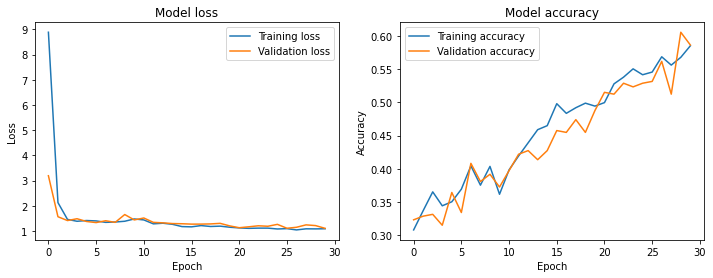

In [31]:
# Plot the training curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='Training loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.set_title('Model loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.show()

### Submissions

In [32]:
ids_sub,X_sub,Y_sub = PreProcess(test_data,image_size) 

100%|██████████| 1821/1821 [00:42<00:00, 43.21it/s]


In [33]:
pred_sub = model.predict(X_sub)
pred_sub.shape

(1821, 4)

In [34]:
submissions = pd.DataFrame(pred_sub)
submissions.columns = ['healthy','multiple_diseases','rust','scab']
submissions.insert(0,'image_id',ids_sub)
submissions.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.324561,0.065681,0.430808,0.178950
1,Test_1,0.372749,0.036061,0.562841,0.028349
2,Test_2,0.019229,0.079562,0.134668,0.766542
3,Test_3,0.669529,0.003781,0.272598,0.054092
4,Test_4,0.142652,0.069912,0.580732,0.206705


In [35]:
submissions.to_csv('submission.csv', index=False)